# Dataset Prep

In [ ]:
!wget -c https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-07-05 19:45:21--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88867207 (85M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  84.75M   162MB/s    in 0.5s    

2020-07-05 19:45:21 (162 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [88867207/88867207]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - ca-certificates==2020.1.1=0
    - certifi==2020.4.5.1=py37_0
    - cffi==1.14.0=py37he30daa8_1
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.1=py37h7b6447c_0
    - conda==4.8.3=py37_0
    - c

In [ ]:
import tensorflow as tf
print("tf.__version__: %s" % str(tf.__version__))

tf.__version__: 2.2.0


In [ ]:
!git clone https://github.com/deepchem/deepchem.git

Cloning into 'deepchem'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 32577 (delta 68), reused 80 (delta 39), pack-reused 32454
Receiving objects: 100% (32577/32577), 440.02 MiB | 38.74 MiB/s, done.
Resolving deltas: 100% (23962/23962), done.


In [ ]:
%cd deepchem

/content/deepchem


In [ ]:
!python setup.py install


running install
running bdist_egg
running egg_info
creating deepchem.egg-info
writing deepchem.egg-info/PKG-INFO
writing dependency_links to deepchem.egg-info/dependency_links.txt
writing requirements to deepchem.egg-info/requires.txt
writing top-level names to deepchem.egg-info/top_level.txt
writing manifest file 'deepchem.egg-info/SOURCES.txt'
reading manifest file 'deepchem.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
no previously-included directories found matching 'datasets'
no previously-included directories found matching 'examples'
writing manifest file 'deepchem.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/deepchem
copying deepchem/__init__.py -> build/lib/deepchem
creating build/lib/deepchem/hyper
copying deepchem/hyper/gaussian_process.py -> build/lib/deepchem/hyper
copying deepchem/hyper/__init__.py -> build/lib/deepchem/hyper
copying 

In [ ]:
import deepchem as dc

In [ ]:
from rdkit import Chem # RDKit libraries for chemistry functions
from rdkit.Chem import Draw # Drawing chemical structures
from rdkit.Chem import AllChem
import pandas as pd # Dealing with data in tables
from rdkit.Chem import PandasTools # Manipulating chemical data
from rdkit.Chem import Descriptors # Calculating molecular descriptors
from rdkit.Chem import rdmolops # Additional molecular properties
import seaborn as sns # Making graphs 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/HIV_pred

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/HIV_pred


In [ ]:
%ls

actives_final.ism                decoys_final.ism  zinc_100k.smi
best_cluster_represenatives.csv  gcn_model/        zinc_69k.csv
best_reps_smi.csv                neutralize.py     zinc69k_smiles.csv
decoys_final_cp.ism              rd_filters.py


In [ ]:
hiv_actives_df = pd.read_csv("actives_final.ism", header=None, sep = " ")
actives_instances, actives_attributes = hiv_actives_df.shape
hiv_actives_df.columns = ["SMILES", "PCBA_SID", "CHEMBL_ID"]

In [ ]:
#NEUTRALIZE CHARGES FUNCTION
from rdkit.Chem import AllChem
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(smiles, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    mol = Chem.MolFromSmiles(smiles)
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = AllChem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    if replaced:
        return (Chem.MolToSmiles(mol,True))
    else:
        return (smiles)

In [ ]:
hiv_actives_df["SMILES"] = [NeutraliseCharges(smile) for smile in hiv_actives_df.SMILES]

,SMILES,PCBA_SID,CHEMBL_ID,Label,Mol
0,CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)OC2CO[...,489942,CHEMBL477992,Active,
1,CC(C)CN(CC(O)C(Cc1ccccc1)NC(=O)O[C@@H]3C[C@@H]...,356299,CHEMBL377329,Active,
2,COc5cc(CN4[C@H](Cc1ccccc1)[C@H](O)CN(Cc2ccccc2...,212772,CHEMBL443030,Active,
3,COc5ccc(S(=O)(=O)N(C[C@@H](O)[C@H](Cc1ccccc1)N...,316166,CHEMBL264818,Active,
4,Nc5cccc(S(=O)(=O)N(C[C@@H](O)[C@H](Cc1ccccc1)N...,316187,CHEMBL362510,Active,

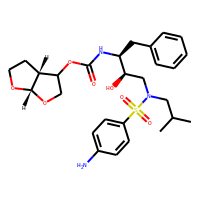
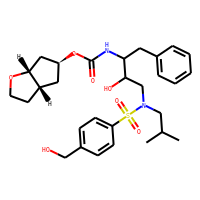
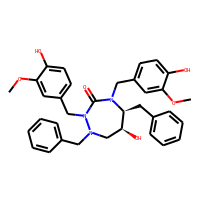
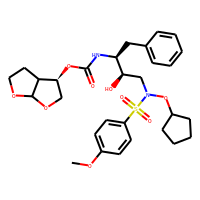
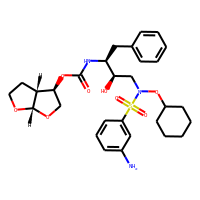

In [ ]:
hiv_actives_df["Label"] = ["Active"]*actives_instances
PandasTools.AddMoleculeColumnToFrame(hiv_actives_df,"SMILES","Mol", includeFingerprints=False)
hiv_actives_df.head()

In [ ]:
def add_property_columns_to_df(df_in):  #Function for defining Molecular Properties
  df_in["mw"] = [Descriptors.MolWt(mol) for mol in df_in.Mol]
  df_in["logP"] = [Descriptors.MolLogP(mol) for mol in df_in.Mol]
  df_in["charge"] = [rdmolops.GetFormalCharge(mol) for mol in df_in.Mol]
  df_in["NumHAcceptors"] = [Descriptors.NumHAcceptors(mol) for mol in df_in.Mol]
  df_in["NumHDonors"] = [Descriptors.NumHDonors(mol) for mol in df_in.Mol]

# Plotting Data 

,SMILES,PCBA_SID,CHEMBL_ID,Label,Mol,mw,logP,charge,NumHAcceptors,NumHDonors
0,CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)OC2CO[...,489942,CHEMBL477992,Active,,547.674,2.3753,0,8,3
1,CC(C)CN(CC(O)C(Cc1ccccc1)NC(=O)O[C@@H]3C[C@@H]...,356299,CHEMBL377329,Active,,560.713,3.0915,0,7,3
2,COc5cc(CN4[C@H](Cc1ccccc1)[C@H](O)CN(Cc2ccccc2...,212772,CHEMBL443030,Active,,583.685,4.9422,0,7,3
3,COc5ccc(S(=O)(=O)N(C[C@@H](O)[C@H](Cc1ccccc1)N...,316166,CHEMBL264818,Active,,590.695,3.0199,0,9,2
4,Nc5cccc(S(=O)(=O)N(C[C@@H](O)[C@H](Cc1ccccc1)N...,316187,CHEMBL362510,Active,,589.711,2.9836,0,9,3

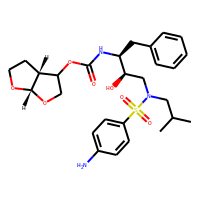
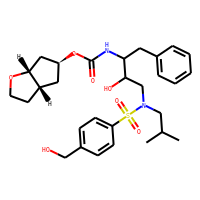
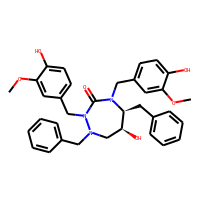
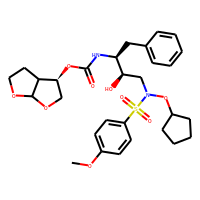
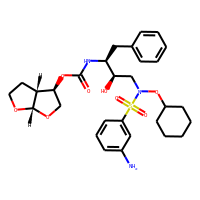

In [ ]:
add_property_columns_to_df(hiv_actives_df)
hiv_actives_df.head()

In [ ]:
hiv_decoys_df = pd.read_csv("decoys_final.ism", header=None, sep = " ")
decoys_instances, decoys_attributes = hiv_decoys_df.shape
hiv_decoys_df.columns = ["SMILES", "PCBA_SID"]

In [ ]:
hiv_decoys_df["SMILES"] = [NeutraliseCharges(smile) for smile in hiv_decoys_df.SMILES]

In [ ]:
hiv_decoys_df["Label"] = ["Decoy"]*decoys_instances
PandasTools.AddMoleculeColumnToFrame(hiv_decoys_df,"SMILES","Mol")
#%cat decoys_final.ism | wc -l
add_property_columns_to_df(hiv_decoys_df)
tmp_df = hiv_actives_df.append(hiv_decoys_df)

In [ ]:
#SUMMARY
hiv_decoys_df.groupby('NumHAcceptors').size()


NumHAcceptors
0        3
1      133
2     1110
3     2678
4     4637
5     5900
6     6785
7     5962
8     4563
9     2251
10     972
11     409
12     242
13      76
14      27
15       2
dtype: int64

In [ ]:
#SUMMARY
hiv_decoys_df.groupby('NumHDonors').size()


NumHDonors
0     2024
1    12705
2    14190
3     5239
4     1276
5      217
6       57
7       27
8       11
9        4
dtype: int64

In [ ]:
hiv_decoys_df.groupby('charge').size()


charge
-1      429
 0    35297
 1       24
dtype: int64

In [ ]:
hiv_actives_df.groupby('NumHAcceptors').size()


NumHAcceptors
1       2
2       9
3      39
4      67
5     138
6     124
7     109
8      36
9       5
10      7
dtype: int64

In [ ]:
hiv_actives_df.groupby('NumHDonors').size()


NumHDonors
0      3
1     95
2    175
3    116
4     95
5     41
6      9
7      2
dtype: int64

In [ ]:
hiv_actives_df.groupby('charge').size()


charge
0    535
1      1
dtype: int64

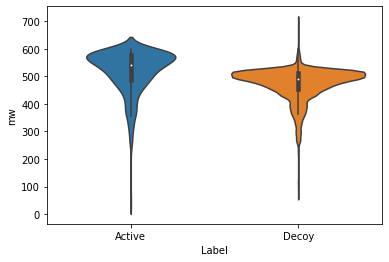

In [ ]:
#VIOLIN PLOTS
sns.violinplot(tmp_df["Label"],tmp_df["mw"])

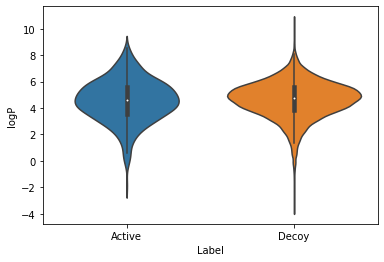

In [ ]:
sns.violinplot(tmp_df["Label"],tmp_df["logP"])


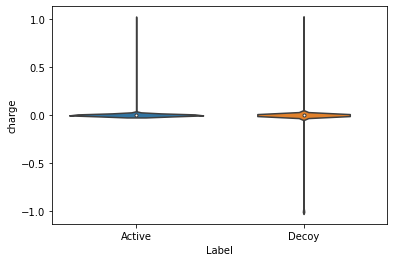

In [ ]:
sns.violinplot(tmp_df["Label"],tmp_df["charge"])


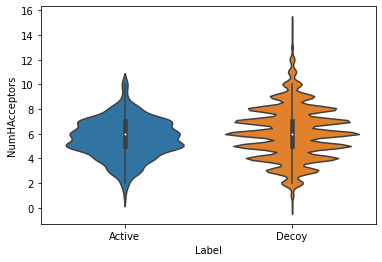

In [ ]:
sns.violinplot(tmp_df["Label"],tmp_df["NumHAcceptors"])


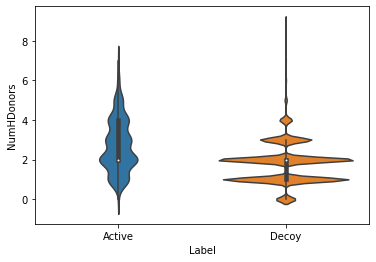

In [ ]:
sns.violinplot(tmp_df["Label"],tmp_df["NumHDonors"])


# N

In [ ]:
hiv_actives_df["is_active"] = [1] * hiv_actives_df.shape[0]
hiv_decoys_df["is_active"] = [0] * hiv_decoys_df.shape[0]

In [ ]:
#APPEND DECOYS TO ACTIVES
essential_df = hiv_actives_df.append(hiv_decoys_df)[["SMILES","PCBA_SID","is_active"]]


#SAVE DF AS CSV
essential_df.to_csv("hiv.csv",index=False)
#%cat hiv.csv | wc -l

In [ ]:
essential_df.head()

,SMILES,PCBA_SID,is_active
0,CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)OC2CO[...,489942,1
1,CC(C)CN(CC(O)C(Cc1ccccc1)NC(=O)O[C@@H]3C[C@@H]...,356299,1
2,COc5cc(CN4[C@H](Cc1ccccc1)[C@H](O)CN(Cc2ccccc2...,212772,1
3,COc5ccc(S(=O)(=O)N(C[C@@H](O)[C@H](Cc1ccccc1)N...,316166,1
4,Nc5cccc(S(=O)(=O)N(C[C@@H](O)[C@H](Cc1ccccc1)N...,316187,1


In [ ]:
essential_df.tail()

,SMILES,PCBA_SID,is_active
35745,CC[C@@H](C)c1ccc2c(c1)nc(o2)c3cc(ccc3Cl)NC(=S)...,C59365877,0
35746,Cc1ccc(cc1)n2c(nnc2SCC(=O)N/N=C\3/c4ccccc4NC3=...,C00863899,0
35747,Cc1cc(c(c(c1)C)NC(=O)CN(C)c2nn3c(c(nc3s2)c4ccc...,C64703548,0
35748,Cc1ccc(cc1NC(=O)Nc2ccc(cc2)Cn3cc(nc3)c4nc(no4)...,C64859943,0
35749,CCCCn1c2ccccc2n3c1nc(c3C(=O)N/N=C\4/c5cc(cc(c5...,C09110355,0


# GCN Model

In [ ]:
import deepchem as dc # DeepChem libraries
from deepchem.models import GraphConvModel # Graph convolutions
import numpy as np # NumPy for numeric operations
import sys # Error handling
import pandas as pd # Data table manipulation
import seaborn as sns # Seaborn library for plotting
from rdkit.Chem import PandasTools # Chemical structures in Pandas 

In [ ]:
dataset_file = "hiv.csv"
tasks = ["is_active"]
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks, smiles_field="SMILES", featurizer=featurizer)
dataset = loader.featurize(dataset_file, shard_size=8192)

/content/deepchem/deepchem/data/data_loader.py:268: FutureWarning: featurize() is deprecated and has been renamed to create_dataset(). featurize() will be removed in DeepChem 3.0
  FutureWarning)


About to start loading CSV from hiv.csv
Loading shard 1 of size 8192.
Loading shard 2 of size 8192.
Loading shard 3 of size 8192.
Loading shard 4 of size 8192.
Loading shard 5 of size 8192.


In [ ]:
splitter = dc.splits.RandomSplitter()
metrics = [dc.metrics.Metric(dc.metrics.matthews_corrcoef, np.mean, mode="classification")] 

In [ ]:
def generate_graph_conv_model():
  batch_size = 128
  model = GraphConvModel(n_tasks=1, n_classes=2, batch_size=batch_size, mode='classification', model_dir="gcn_model")
  return model

In [ ]:
training_score_list = []
validation_score_list = []
transformers = []
cv_folds = 10
for i in range(0,cv_folds):
    model = generate_graph_conv_model()
    train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)
    model.fit(train_dataset)
    train_scores = model.evaluate(train_dataset, metrics, transformers)
    training_score_list.append(train_scores["mean-matthews_corrcoef"])
    validation_scores = model.evaluate(valid_dataset, metrics, transformers)
    validation_score_list.append(validation_scores["mean-matthews_corrcoef"])
print(training_score_list)
print(validation_score_list)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[0.9608011246578743, 0.9039553334250588, 0.640900652548225, 0.7490156167064365, 0.8321076698203654, 0.909154009450123, 0.7506354073523293, 0.5119519473284815, 0.9288676329110809, 0.8664328255416073]
[0.9742700486310634, 0.8212045911404341, 0.5267982308716033, 0.7213603636418742, 0.7900232095497116, 0.942152077498677, 0.7261026407395145, 0.5132437380100351, 0.9351665576436445, 0.8755905480850746]


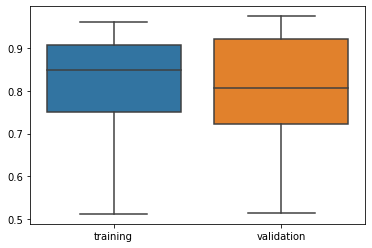

In [ ]:
sns.boxplot(["training"]*cv_folds+["validation"]*cv_folds,training_score_list+validation_score_list)


In [ ]:
pred = [x.flatten() for x in model.predict(valid_dataset)]

In [ ]:
pred

[array([0.00795008, 0.9920499 ], dtype=float32),
 array([0.794795  , 0.20520504], dtype=float32),
 array([0.14546202, 0.85453796], dtype=float32),
 array([0.91198266, 0.08801738], dtype=float32),
 array([0.45451427, 0.54548573], dtype=float32),
 array([0.16397524, 0.83602476], dtype=float32),
 array([0.05314304, 0.9468569 ], dtype=float32),
 array([0.9433761 , 0.05662389], dtype=float32),
 array([0.2480827, 0.7519173], dtype=float32),
 array([0.7501444 , 0.24985553], dtype=float32),
 array([0.05611431, 0.94388574], dtype=float32),
 array([0.03974973, 0.96025026], dtype=float32),
 array([0.0145619, 0.9854381], dtype=float32),
 array([0.47321147, 0.52678853], dtype=float32),
 array([0.0098698 , 0.99013025], dtype=float32),
 array([0.0334339 , 0.96656615], dtype=float32),
 array([0.6106388, 0.3893612], dtype=float32),
 array([0.5214963 , 0.47850367], dtype=float32),
 array([0.9592807 , 0.04071926], dtype=float32),
 array([0.17190148, 0.8280985 ], dtype=float32),
 array([0.3083574, 0.69164

In [ ]:
pred_df = pd.DataFrame(pred,columns=["neg","pos"])

In [ ]:
pred_df["active"] = [int(x) for x in valid_dataset.y]
pred_df["SMILES"] = valid_dataset.ids

In [ ]:
pred_df.head()

,neg,pos,active,SMILES
0,0.007950,0.992050,1,Cc1c(O)cccc1C(=O)N[C@H](CSc2ccccc2)[C@H](O)CN4...
1,0.794795,0.205205,1,CC(C)C3(CCc1ccc(O)cc1)CC(=O)C(Sc2cc(C)c(OS(C)(...
2,0.145462,0.854538,1,O[C@@H]6[C@@H](CCc1ccccc1)N(Cc3ccc2c[nH]nc2c3)...
3,0.911983,0.088017,1,CC(C)CC(c2cccc(NS(=O)(=O)c1cn(C)cn1)c2)c4c(O)c...
4,0.454514,0.545486,1,O[C@@H]4[C@@H](O)[C@@H](Cc1ccccc1)N(C/C=C/c2cn...


In [ ]:
pred_df.sort_values("pos",ascending=False).head(25)

,neg,pos,active,SMILES
48,0.002318,0.997682,1,CC(C)(C)NC(=O)[C@@H]2C[C@@H]1CCCC[C@@H]1CN2C[C...
42,0.002576,0.997424,1,CC(C)(C)NC(=O)[C@@H]2C[C@@H]1CCCC[C@@H]1CN2C[C...
25,0.002717,0.997283,1,CC(C)(C)OC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)C[C@@...
26,0.006502,0.993498,1,N/C(=N\O)c5cccc(CN4[C@H](Cc1ccccc1)[C@H](O)[C@...
50,0.006722,0.993278,1,CC(C)(C)NC(=O)[C@@H]2CN(C(=O)c1ccccn1)CCN2C[C@...
0,0.007950,0.992050,1,Cc1c(O)cccc1C(=O)N[C@H](CSc2ccccc2)[C@H](O)CN4...
14,0.009870,0.990130,1,O[C@@H]4[C@@H](O)[C@@H](Cc1ccccc1)N(CC2CCC2)C(...
24,0.011850,0.988150,1,CC(C)(C)NC(=O)[C@@H]2C[C@@H]1CCCC[C@@H]1CN2C[C...
12,0.014562,0.985438,1,CC(C)(C)OC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)C[C@@...
28,0.019804,0.980196,1,COc3ccc(S(=O)(=O)N(C[C@@H](O)[C@H](Cc1ccccc1)N...


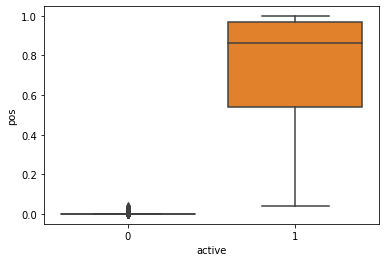

In [ ]:
sns.boxplot(pred_df.active,pred_df.pos)

In [ ]:
false_negative_df = pred_df.query("active == 1 & pos < 0.5").copy()
PandasTools.AddMoleculeColumnToFrame(false_negative_df,"SMILES","Mol")

,neg,pos,active,SMILES,Mol
1,0.794795,0.205205,1,CC(C)C3(CCc1ccc(O)cc1)CC(=O)C(Sc2cc(C)c(OS(C)(...,
3,0.911983,0.088017,1,CC(C)CC(c2cccc(NS(=O)(=O)c1cn(C)cn1)c2)c4c(O)c...,
7,0.943376,0.056624,1,CCC(CC1CCOCC1)c5cc(O)c(C(C2CC2)c4cccc(NS(=O)(=...,
9,0.750144,0.249856,1,CCC(CC)c4cc(O)c(C(C1CC1)c3cccc(NS(=O)(=O)c2cn(...,
16,0.610639,0.389361,1,Oc3oc(C(CC1CC1)CC2CC2)cc(=O)c3C(C4CC4)c6cccc(C...,
17,0.521496,0.478504,1,Cc1c(O)cccc1C(=O)N[C@@H](CSc3ccc2ccccc2c3)[C@H...,
18,0.959281,0.040719,1,Cn1ccnc1S(=O)(=O)Cc6cccc(C(C2CC2)c5c(O)cc(C(CC...,
30,0.745279,0.254721,1,CC(C)CCN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)[C@H]...,
37,0.904694,0.095306,1,CC(C)[C@H](NC(C)=O)C(=O)N[C@@H](Cc1ccccc1)[C@@...,
46,0.905915,0.094085,1,CC(C)CN([C@@H](CCCCNC(=O)CC2c1ccccc1c3ccccc23)...,

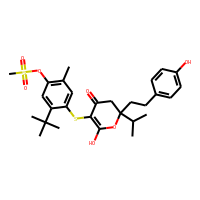
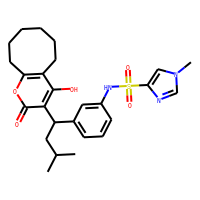
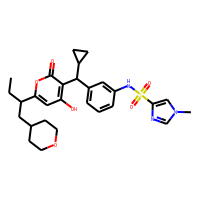
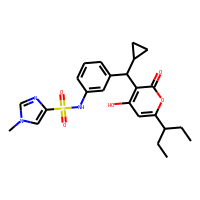
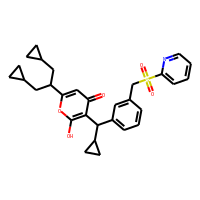
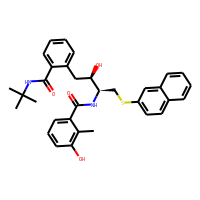
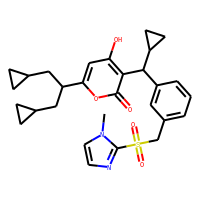
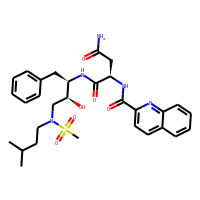
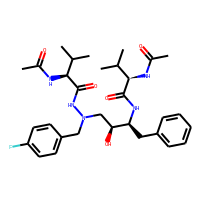
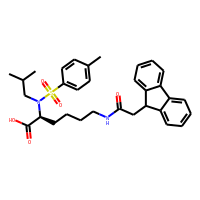
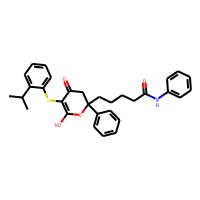
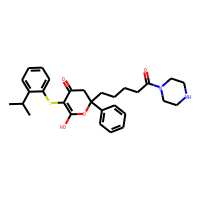

In [ ]:
false_negative_df

In [ ]:
false_positive_df = pred_df.query("active == 0 & pos > 0.5").copy()
PandasTools.AddMoleculeColumnToFrame(false_positive_df,"SMILES","Mol")

In [ ]:
false_positive_df

,neg,pos,active,SMILES,Mol


In [ ]:
model.fit(dataset)

0.00013333969605220874

In [ ]:
%ls

actives_final.ism                decoys_final.ism  rd_filters.py
best_cluster_represenatives.csv  gcn_model/        zinc_100k.smi
best_reps_smi.csv                hiv.csv           zinc_69k.csv
decoys_final_cp.ism              neutralize.py     zinc69k_smiles.csv


In [ ]:
model.save_checkpoint(max_checkpoints_to_keep=1, model_dir="gcn_model")

# Prediction on ZINC Compounds

In [ ]:
model = dc.models.GraphConvModel(1, batch_size=128, mode='classification',model_dir="gcn_model")
model.restore()

In [ ]:
featurizer = dc.feat.ConvMolFeaturizer()

In [ ]:
%cat zinc_69k.csv| head

,SMILES,NAME,FILTER,MW,LogP,HBD,HBA,TPSA,Rot
3,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436,OK,308.38200000000006,-1.0162999999999975,0,5,64.17000000000002,3
4,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C@@H]1NC(C)=O,ZINC000000041101,OK,302.327,-1.1354999999999982,3,6,106.12,4
6,C1CN(c2nc(-c3nn[nH]n3)nc(N3CCOCC3)n2)CCO1,ZINC000000054542,OK,319.3290000000001,-1.2750999999999988,1,10,118.07,3
19,OCCN(CCO)c1nc(Cl)nc(N(CCO)CCO)n1,ZINC000000109481,OK,321.7650000000001,-1.8929999999999985,4,9,126.07,10
24,COC(=O)c1ccc(S(=O)(=O)N(CCO)CCO)n1C,ZINC000000119782,OK,306.3400000000001,-1.212999999999999,2,7,109.07000000000002,7
25,O=c1c2cc3c(=O)n(CCO)c(=O)c3cc2c(=O)n1CCO,ZINC000000134422,OK,304.2580000000001,-2.1029999999999993,2,8,118.6,4
27,CN(C)c1nc2c(ncnc2N)n1[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O,ZINC000000158666,OK,310.314,-1.9139999999999988,4,10,142.78000000000003,3
47,CN(C)c1nc2c(ncnc2N)n1[C@H]1O[C@@H](CO)[C@H](O)[C@@H]1O,ZINC000000519310,OK,310.314,-1.9139999999999988,4,10,14

In [ ]:
filtered_df = pd.read_csv("zinc_69k.csv", sep=",", header=0)
filtered_df.head()

,Unnamed: 0,SMILES,NAME,FILTER,MW,LogP,HBD,HBA,TPSA,Rot
0,3,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436,OK,308.382,-1.0163,0,5,64.17,3
1,4,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C...,ZINC000000041101,OK,302.327,-1.1355,3,6,106.12,4
2,6,C1CN(c2nc(-c3nn[nH]n3)nc(N3CCOCC3)n2)CCO1,ZINC000000054542,OK,319.329,-1.2751,1,10,118.07,3
3,19,OCCN(CCO)c1nc(Cl)nc(N(CCO)CCO)n1,ZINC000000109481,OK,321.765,-1.8930,4,9,126.07,10
4,24,COC(=O)c1ccc(S(=O)(=O)N(CCO)CCO)n1C,ZINC000000119782,OK,306.340,-1.2130,2,7,109.07,7


In [ ]:
zinc69k_smiles_df = filtered_df[["SMILES","NAME"]].copy()
zinc69k_smiles_df.head()

,SMILES,NAME
0,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436
1,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C...,ZINC000000041101
2,C1CN(c2nc(-c3nn[nH]n3)nc(N3CCOCC3)n2)CCO1,ZINC000000054542
3,OCCN(CCO)c1nc(Cl)nc(N(CCO)CCO)n1,ZINC000000109481
4,COC(=O)c1ccc(S(=O)(=O)N(CCO)CCO)n1C,ZINC000000119782


In [ ]:
rows,cols = zinc69k_smiles_df.shape
zinc69k_smiles_df["Value"] = [0] * rows

In [ ]:
zinc69k_smiles_df.head()

,SMILES,NAME,Value
0,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436,0
1,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C...,ZINC000000041101,0
2,C1CN(c2nc(-c3nn[nH]n3)nc(N3CCOCC3)n2)CCO1,ZINC000000054542,0
3,OCCN(CCO)c1nc(Cl)nc(N(CCO)CCO)n1,ZINC000000109481,0
4,COC(=O)c1ccc(S(=O)(=O)N(CCO)CCO)n1C,ZINC000000119782,0


In [ ]:
zinc69k_smiles_df.to_csv("zinc69k_smiles.csv",index=False)

In [ ]:
loader = dc.data.CSVLoader(tasks=['Value'], smiles_field="SMILES", featurizer=featurizer)

In [ ]:
dataset = loader.featurize("zinc69k_smiles.csv", shard_size=8192)

/content/deepchem/deepchem/data/data_loader.py:268: FutureWarning: featurize() is deprecated and has been renamed to create_dataset(). featurize() will be removed in DeepChem 3.0
  FutureWarning)


About to start loading CSV from zinc69k_smiles.csv
Loading shard 1 of size 8192.
Loading shard 2 of size 8192.
Loading shard 3 of size 8192.
Loading shard 4 of size 8192.
Loading shard 5 of size 8192.
Loading shard 6 of size 8192.
Loading shard 7 of size 8192.
Loading shard 8 of size 8192.
Loading shard 9 of size 8192.


In [ ]:
pred = model.predict(dataset)

In [ ]:
pred_df = pd.DataFrame([x.flatten() for x in pred],columns=["Neg","Pos"])


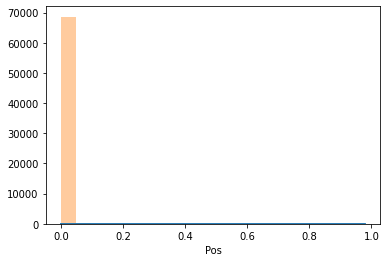

In [ ]:
sns.distplot(pred_df.Pos)
sns.distplot(pred_df.Pos, bins=20, kde=False, rug=False)

In [ ]:
full_df = zinc69k_smiles_df.join(pred_df,how="outer")

In [ ]:
full_df.sort_values("Pos",inplace=True,ascending=False)

In [ ]:
PandasTools.AddMoleculeColumnToFrame(full_df,"SMILES","Mol")

NameError: ignored

,SMILES,NAME,Value,Neg,Pos,Mol
51468,CN(CC(=O)N1C[C@H](O)[C@@H](O)C1)S(=O)(=O)c1ccccc1,ZINC000628523995,0,0.020382,0.979618,
1833,O=S(=O)(c1cn[nH]c1)N1C[C@@H](O)[C@H](N2CCOCC2)C1,ZINC000257224614,0,0.028363,0.971637,
51463,CN(CC(=O)N1C[C@H](O)[C@@H](O)C1)S(=O)(=O)c1cccnc1,ZINC000628523664,0,0.074301,0.925699,
1920,CN1CCN([C@@H]2CN(S(=O)(=O)c3cn[nH]c3)C[C@H]2O)CC1,ZINC000257274645,0,0.139947,0.860053,
64296,CN(CC(=O)NC[C@H](O)C(N)=O)S(=O)(=O)c1ccccc1,ZINC000683913277,0,0.312869,0.687132,
64297,CN(CC(=O)NC[C@@H](O)C(N)=O)S(=O)(=O)c1ccccc1,ZINC000683913280,0,0.312869,0.687132,
51453,O=C(CCNS(=O)(=O)c1ccccc1)N1C[C@H](O)[C@@H](O)C1,ZINC000628522534,0,0.354276,0.645724,
31777,O=S(=O)(c1ccc(-n2cnnn2)cc1)N1C[C@@H](O)[C@@H](...,ZINC000434775875,0,0.365821,0.634179,
31778,O=S(=O)(c1ccc(-n2cnnn2)cc1)N1C[C@H](O)[C@@H](O)C1,ZINC000434775879,0,0.365821,0.634179,
31776,O=S(=O)(c1ccc(-n2cnnn2)cc1)N1C[C@@H](O)[C@H](O)C1,ZINC000434775872,0,0.365821,0.634179,

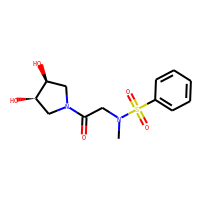
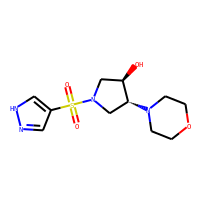
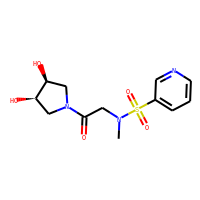
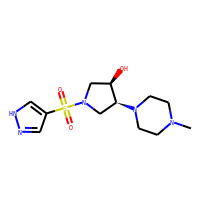
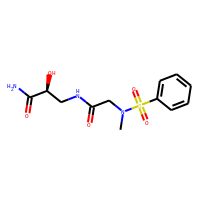
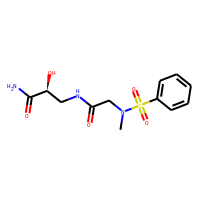
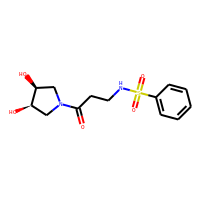
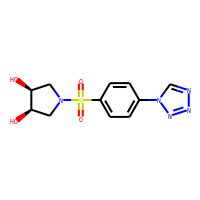
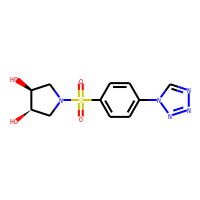
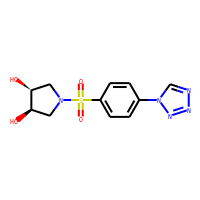
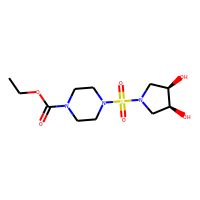
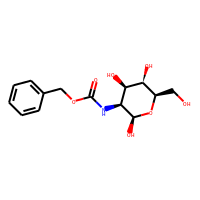
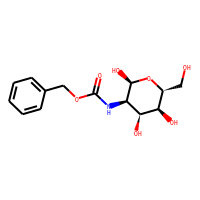
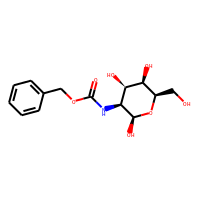
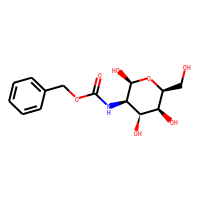
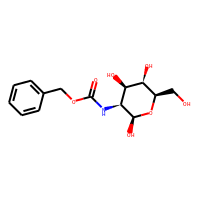
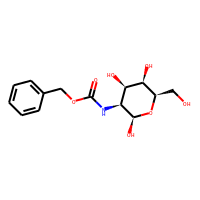
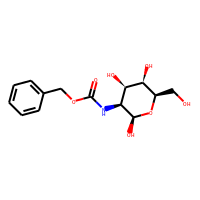
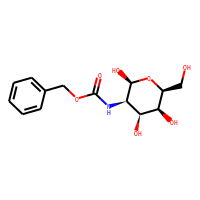
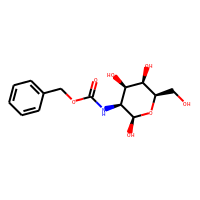
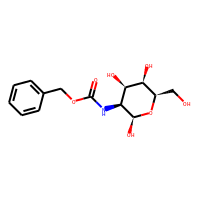
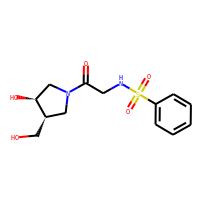
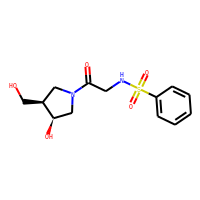
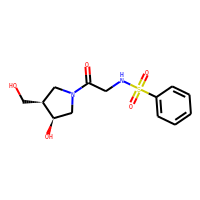
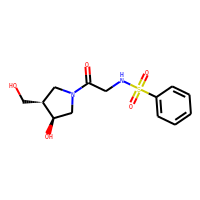
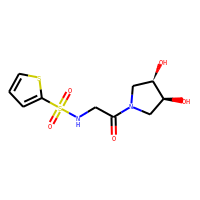
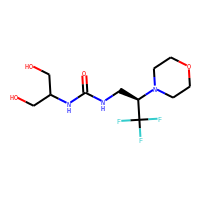
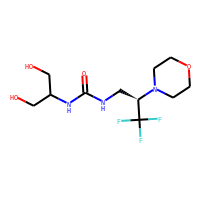
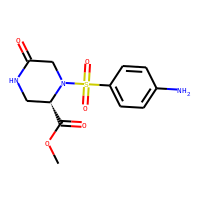
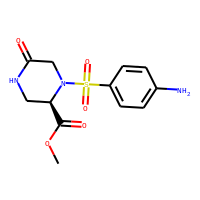

In [ ]:
full_df.query("Pos >= 0.5")

In [ ]:
best_df = full_df.query("Pos >= 0.5").copy()
best_df.shape

(30, 6)

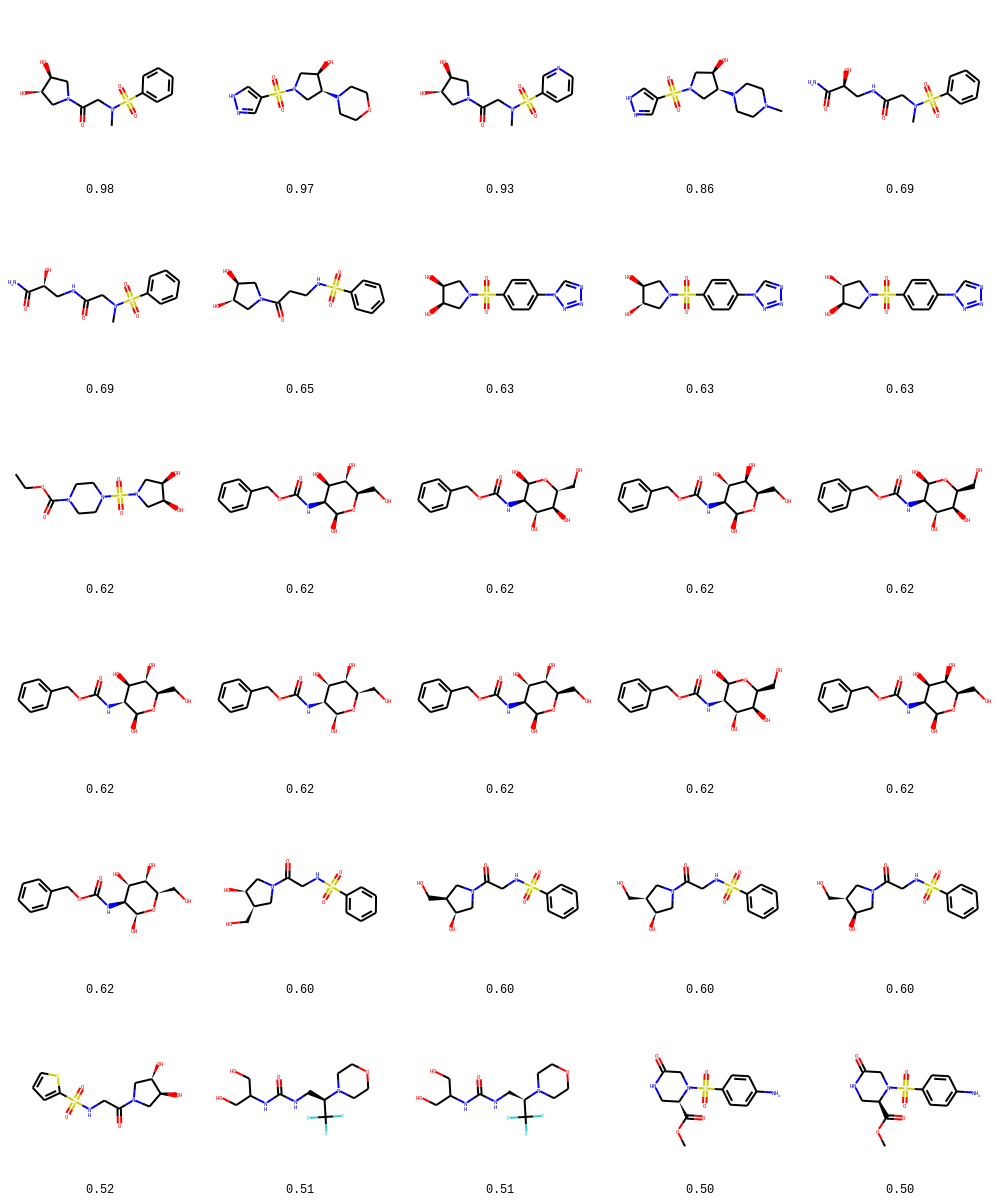

In [ ]:
Draw.MolsToGridImage(best_df.Mol[:1000],molsPerRow=5,legends=["%.2f" % x for x in best_df.Pos[:1000]])

In [ ]:
import pandas as pd
from rdkit.Chem import PandasTools, Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors as rdmd

In [ ]:
def butina_cluster(mol_list,cutoff):
    fp_list = [rdmd.GetMorganFingerprintAsBitVect(m, 3, nBits=2048) for m in mol_list]
    dists = []
    nfps = len(fp_list)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        dists.extend([1-x for x in sims])
    mol_clusters = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    cluster_id_list = [0]*nfps
    for idx,cluster in enumerate(mol_clusters,1):
        for member in cluster:
            cluster_id_list[member] = idx
    return cluster_id_list

In [ ]:
best_df["Cluster"] = butina_cluster(best_df.Mol, 0.7)

In [ ]:
#best_df

In [ ]:
len(best_df.Cluster.unique())

7

In [ ]:
cluster_reps_df = best_df.drop_duplicates("Cluster")
#cluster_reps_df

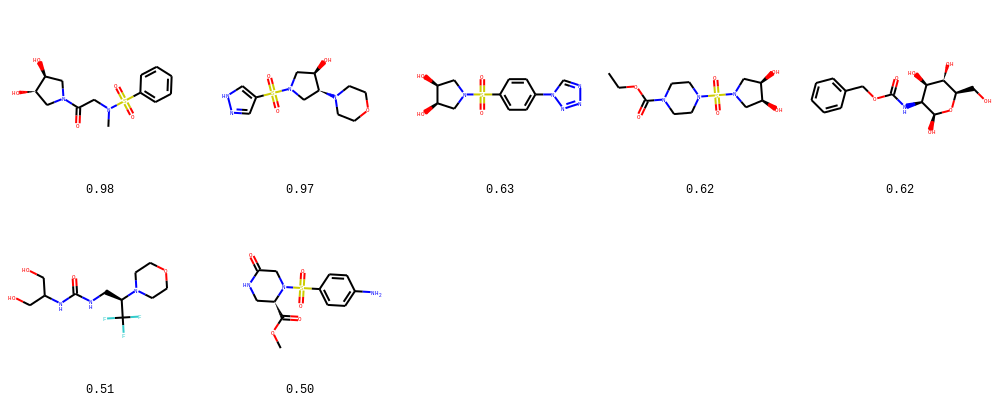

In [ ]:
Draw.MolsToGridImage(cluster_reps_df.Mol[:100],molsPerRow=5,legends=["%.2f" % x for x in cluster_reps_df.Pos[:100]])

In [ ]:
cluster_reps_df.shape

(7, 7)

In [ ]:
cluster_reps_df.to_csv("best_cluster_represenatives.csv")

,SMILES,NAME,Value,Neg,Pos,Mol,Cluster
51468,CN(CC(=O)N1C[C@H](O)[C@@H](O)C1)S(=O)(=O)c1ccccc1,ZINC000628523995,0,0.020381784066557884,0.9796182513237,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",2
1833,O=S(=O)(c1cn[nH]c1)N1C[C@@H](O)[C@H](N2CCOCC2)C1,ZINC000257224614,0,0.028363237157464027,0.9716367125511169,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",6
31777,O=S(=O)(c1ccc(-n2cnnn2)cc1)N1C[C@@H](O)[C@@H](O)C1,ZINC000434775875,0,0.3658212125301361,0.6341786980628967,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",3
68110,CCOC(=O)N1CCN(S(=O)(=O)N2C[C@@H](O)[C@@H](O)C2)CC1,ZINC000758497049,0,0.3788178563117981,0.6211821436882019,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",7
236,O=C(N[C@@H]1[C@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O)OCc1ccccc1,ZINC000016124945,0,0.3842979073524475,0.6157021522521973,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",1
22784,O=C(NC[C@@H](N1CCOCC1)C(F)(F)F)NC(CO)CO,ZINC000358194975,0,0.4
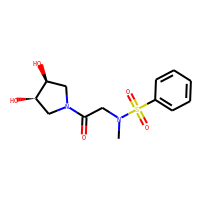
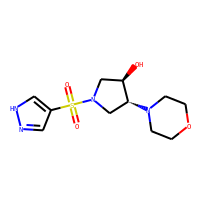
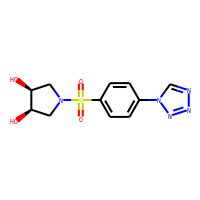
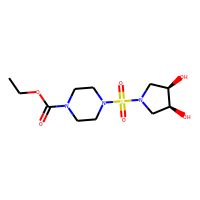
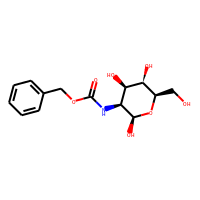
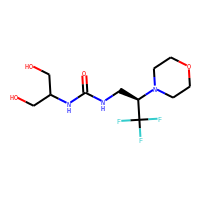
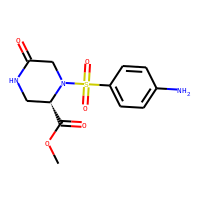

In [ ]:
%cat best_cluster_represenatives.csv| head

In [ ]:
df = pd.read_csv("best_cluster_represenatives.csv", sep=",", header=0)
df.head()
best_reps_smi_df = df[["SMILES","NAME"]].copy()
best_reps_smi_df.to_csv("best_reps_smi.csv", sep = " ", header=None, index=False, index_label=False)

In [ ]:
%cat best_reps_smi.csv

CN(CC(=O)N1C[C@H](O)[C@@H](O)C1)S(=O)(=O)c1ccccc1 ZINC000628523995
O=S(=O)(c1cn[nH]c1)N1C[C@@H](O)[C@H](N2CCOCC2)C1 ZINC000257224614
O=S(=O)(c1ccc(-n2cnnn2)cc1)N1C[C@@H](O)[C@@H](O)C1 ZINC000434775875
CCOC(=O)N1CCN(S(=O)(=O)N2C[C@@H](O)[C@@H](O)C2)CC1 ZINC000758497049
O=C(N[C@@H]1[C@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O)OCc1ccccc1 ZINC000016124945
O=C(NC[C@@H](N1CCOCC1)C(F)(F)F)NC(CO)CO ZINC000358194975
COC(=O)[C@@H]1CNC(=O)CN1S(=O)(=O)c1ccc(N)cc1 ZINC000447938551
